# Quick Overview
This notebook is aimed as my learning canvas of doing time series analysis with Python. After learn the theory about composition, autocorrelation, and stationarity, I apply those concepts with Python.

Using plane arrival data set, I learn how to describe time series data, see inter-temporal pattern, decompose time-series component, and test its stationarity.

# Quick Set Up

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = pd.read_csv('aus_arrivals.csv')

In [ ]:
dataset

,Quarter,Origin,Arrivals
0,1981 Q1,Japan,14763
1,1981 Q2,Japan,9321
2,1981 Q3,Japan,10166
3,1981 Q4,Japan,19509
4,1982 Q1,Japan,17117
...,...,...,...
503,2011 Q3,US,101925
504,2011 Q4,US,127150
505,2012 Q1,US,129520
506,2012 Q2,US,105700


In [ ]:
# Practical of quarter:
# Pembabakan quarter bisa dilihat as bulan pertama dari setiap quarter OR tanggal pertama dari bulan pertama di setiap quarter
# For easier purpose, kita pakai month saja

# Function to map Q1/Q2/Q3/Q4 as their respective month
def map_quarter_to_month(quarter):
    quarter_to_month = {
        'Q1': '01',  # January
        'Q2': '04',  # April
        'Q3': '07',  # July
        'Q4': '10'   # October
    }
    return quarter_to_month[quarter]

In [ ]:
# To datetime tries to understand the date input
# First, we split the year and the Q
# Then apply mapping for the Q
# Join the year and month with '-' sign to make the machine easier to read
dataset['Quarter'] = dataset['Quarter'].apply(lambda x: pd.to_datetime(x.split()[0] + '-' + map_quarter_to_month(x.split()[1]) + '-01'))

In [ ]:
dataset

,Quarter,Origin,Arrivals
0,1981-01-01,Japan,14763
1,1981-04-01,Japan,9321
2,1981-07-01,Japan,10166
3,1981-10-01,Japan,19509
4,1982-01-01,Japan,17117
...,...,...,...
503,2011-07-01,US,101925
504,2011-10-01,US,127150
505,2012-01-01,US,129520
506,2012-04-01,US,105700


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Quarter   508 non-null    datetime64[ns]
 1   Origin    508 non-null    object        
 2   Arrivals  508 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.0+ KB


In [ ]:
data_jpn = dataset.loc[dataset['Origin'] == 'Japan']
data_jpn

,Quarter,Origin,Arrivals
0,1981-01-01,Japan,14763
1,1981-04-01,Japan,9321
2,1981-07-01,Japan,10166
3,1981-10-01,Japan,19509
4,1982-01-01,Japan,17117
...,...,...,...
122,2011-07-01,Japan,96467
123,2011-10-01,Japan,89900
124,2012-01-01,Japan,98180
125,2012-04-01,Japan,59760


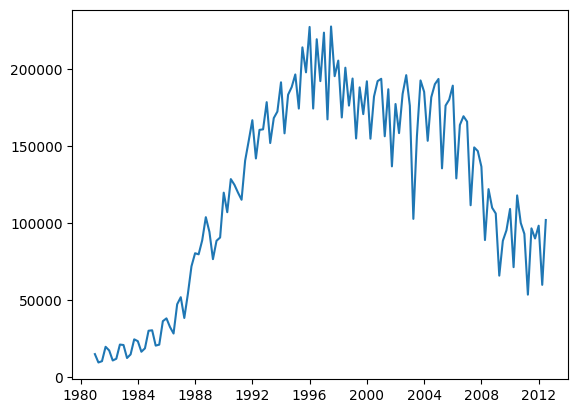

In [ ]:
plt.plot(data_jpn['Quarter'],
         data_jpn['Arrivals']);

# Descriptive Statistics

In [ ]:
data_jpn['Arrivals'].describe()

,Arrivals
count,127.000000
mean,122080.188976
std,64213.918586
min,9321.000000
25%,74134.500000
50%,135461.000000
75%,176752.500000
max,227641.000000


The standard deviation is really huge because there are a lot of fluctuations and trend structure. We need to examine quarterly average

In [ ]:
data_jpn['Year'] = data_jpn['Quarter'].dt.year
data_jpn['Quarter_Num'] = data_jpn['Quarter'].dt.quarter

for quarter in data_jpn['Quarter_Num'].unique():  # Loop over unique quarter numbers (1, 2, 3, 4)
    # Filter the data for the current quarter
    quarter_data = data_jpn[data_jpn['Quarter_Num'] == quarter]

    # Calculate the average for 'Arrivals' in the current quarter
    avg_arrivals = quarter_data['Arrivals'].mean()

    # Print the result
    print(f"Quarter {quarter} Average Arrivals: {avg_arrivals}")

Quarter 1 Average Arrivals: 131511.3125
Quarter 2 Average Arrivals: 101530.53125
Quarter 3 Average Arrivals: 127253.78125
Quarter 4 Average Arrivals: 128216.90322580645


<ipython-input-12-131e4141da55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn['Year'] = data_jpn['Quarter'].dt.year
<ipython-input-12-131e4141da55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn['Quarter_Num'] = data_jpn['Quarter'].dt.quarter


In [ ]:
# Centering bertujuan untuk di tengah2 (mis. window 4, berarti dia butuh 2 data awal dan 2 data akhir)
window = data_jpn['Arrivals'].rolling(window=8, center=True,
                                      closed='right')

# Dia dimasukkan as a part of dataset (jadinya bolong-bolong)
# Konsep rolling itu PER BARIS, jadi bukan tiap 4 baris
data_jpn['Rolling_Avg'] = window.mean()

<ipython-input-80-71f3c73b21ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn['Rolling_Avg'] = window.mean()


In [ ]:
def rmse(input, col_out, col_in):
  gap = []
  input_cleaned = input.dropna(subset=[col_in, col_out])
  for i, j in zip(input_cleaned[col_in], input_cleaned[col_out]):
    if not np.isnan(j):
      row_gap = i - j
      power_two = np.power(row_gap, 2)
      gap.append(power_two)

  if len(gap) > 0:
    avg_sqr_gap = sum(gap)/len(gap)
    sqrt_gap = np.sqrt(avg_sqr_gap)
    return sqrt_gap
  else:
    print('Sorry, division by zero!')

In [ ]:
rmse(data_jpn, 'Arrivals', 'Rolling_Avg')

0.0

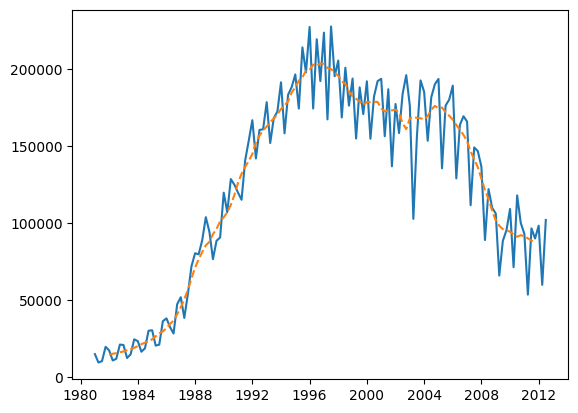

In [ ]:
# Plot original data agar X gak bolong-bolong
plt.plot(data_jpn['Quarter'], data_jpn['Arrivals'], label='Original Arrivals')
plt.plot(data_jpn['Quarter'], data_jpn['Rolling_Avg'], label='Rolling Average (window=4)', linestyle='--')

There are two insights:
- It exhibits additive rule
- Even I try to role it, it still has a lot of deviation (errors)
- Huge drops around 2000-2004

# Autocorrelation Function

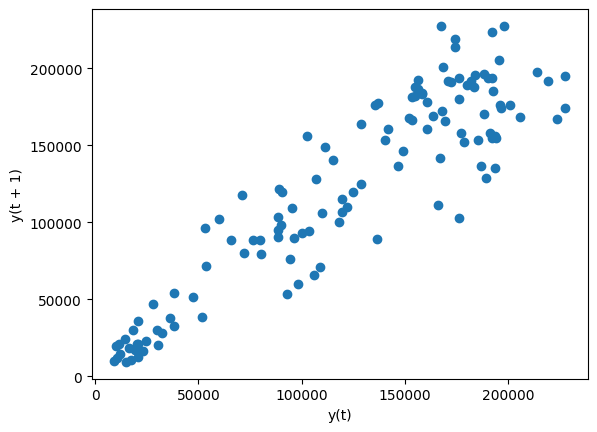

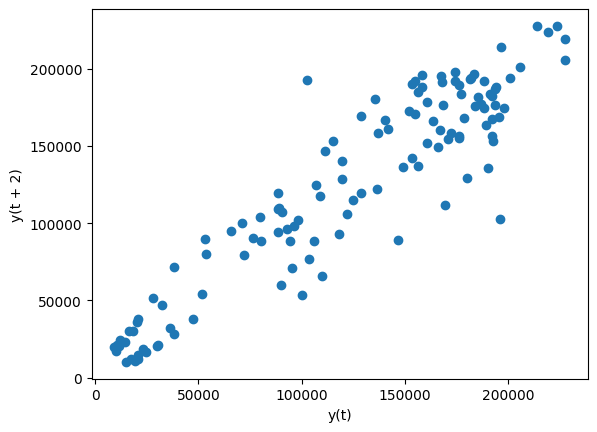

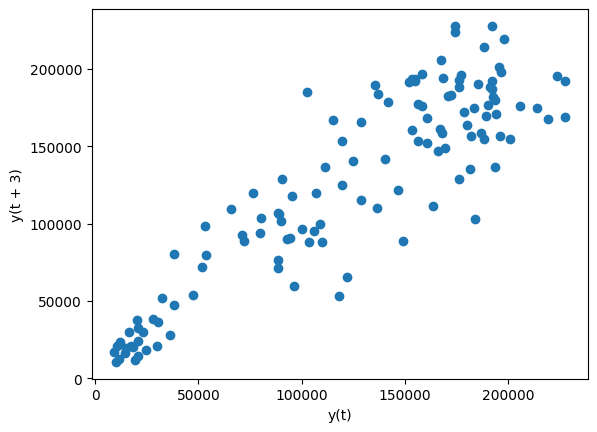

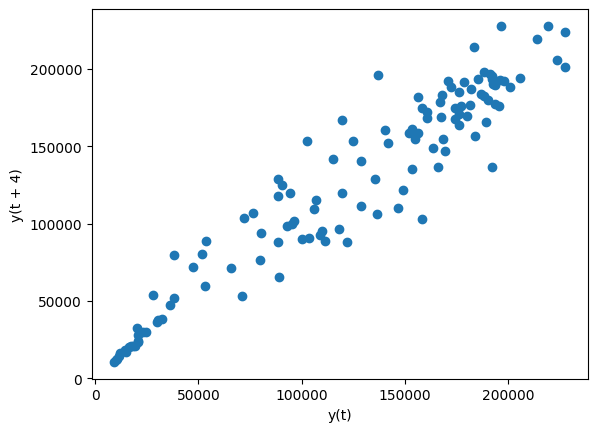

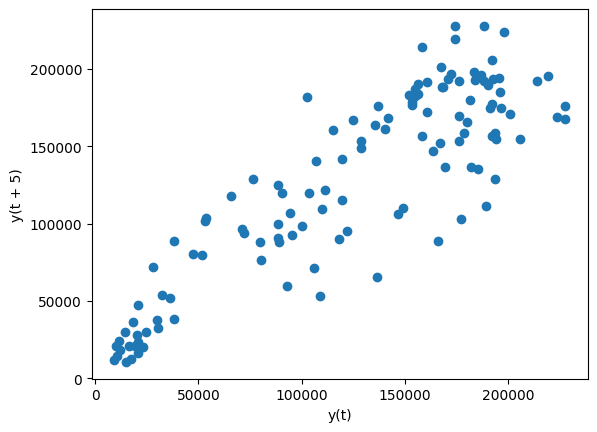

In [ ]:
# Before go to autocorrelation function, let's plot how arrivals related to its lag (previous period)
# Since the interval is quarterly-month, the lag refers to previous quarter

# Lag exhibits unique behavior: every even lags (2, 4), the correlation seems more compact,
# While even lags (1, 3, 5) the correlation seems more scattered, though still related

for i in range (5):
  pd.plotting.lag_plot(data_jpn['Arrivals'], lag=i+1)
  plt.show();

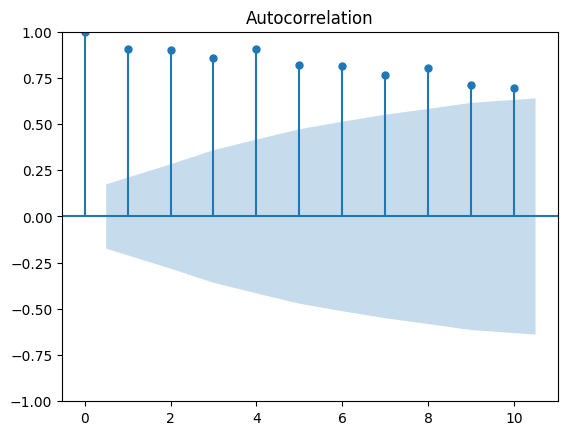

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_jpn['Arrivals'], lags=10)
plt.show()

From Autocorrelation function, we can confirm that:
1. There is a trend (exhibits lower and lower AC overtime). If there is a trend, current information does not fully "rely" to its previous info
2. There is a seasonal pattern: ACF decreases steadily and increases a bit on even lags.

For example, January's arrival information is more informative for March, rather than February (even leap). But, how is the mechanism? Let's see

# Decomposition


## Manual Decompose

In [ ]:
# Detrend the data
data_jpn['detrend'] = data_jpn['Arrivals'] - data_jpn['Rolling_Avg']

<ipython-input-131-ba394df0de65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn['detrend'] = data_jpn['Arrivals'] - data_jpn['Rolling_Avg']


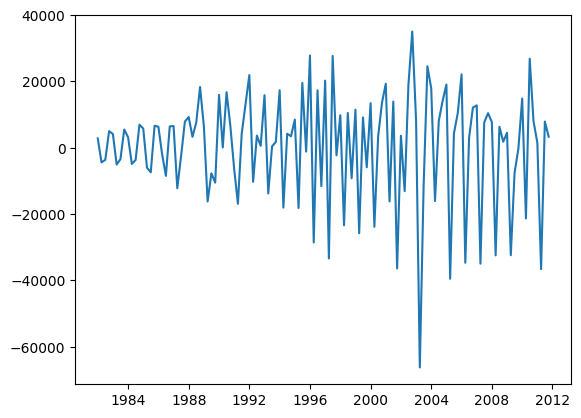

In [ ]:
plt.plot(data_jpn['Quarter'], data_jpn['detrend'], label='Original Arrivals');

In [ ]:
data_jpn["Seasonal"] = data_jpn.groupby(data_jpn['Quarter'].dt.quarter)['detrend'].transform(func = "mean")

<ipython-input-133-9a51e458d3f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn["Seasonal"] = data_jpn.groupby(data_jpn['Quarter'].dt.quarter)['detrend'].transform(func = "mean")


In [ ]:
# It is shown that after detrending the data, we get the pattern
# Even quarters have lesser arrivals than the odd counterpart
# It may exhibit inter-temporal relation
data_jpn['Seasonal'].unique()

array([ 11087.81666667, -20092.90416667,   5523.98333333,   4627.38333333])

In [ ]:
data_jpn['resid'] = data_jpn['detrend'] - data_jpn['Seasonal']

<ipython-input-135-7f9ad44cf310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_jpn['resid'] = data_jpn['detrend'] - data_jpn['Seasonal']


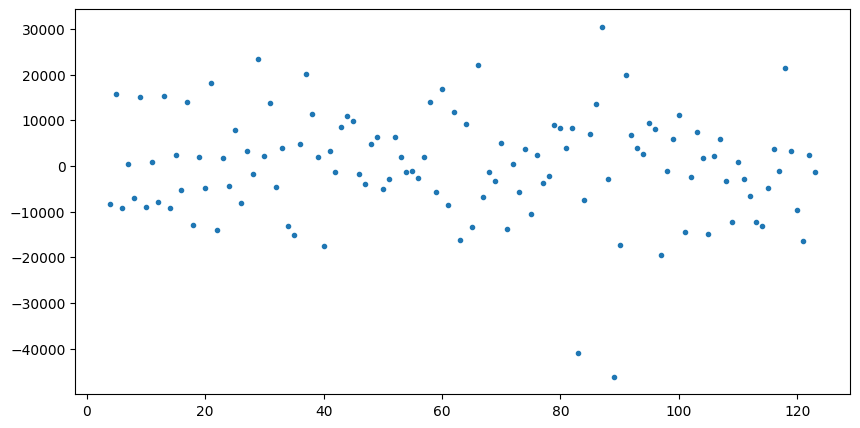

In [ ]:
data_jpn['resid'].plot(figsize = (10,5),
                       ls = " ",
                       marker = ".");

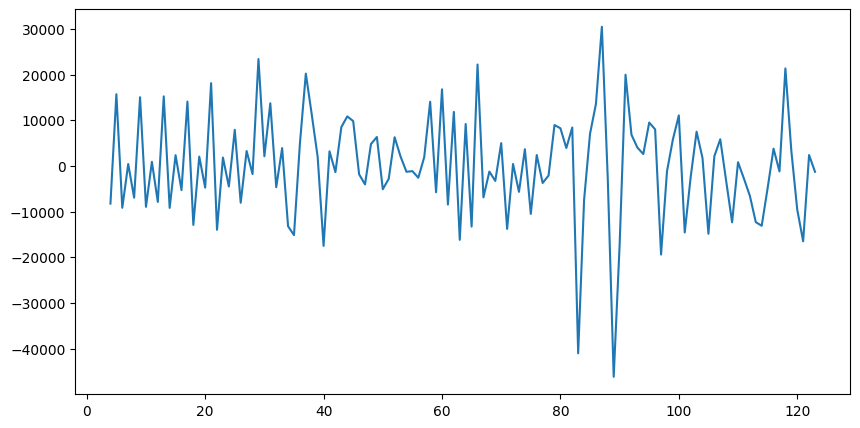

In [ ]:
data_jpn['resid'].plot(figsize = (10,5));

## STL Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose the seasonal component. First, we focus on quarterly
res = seasonal_decompose(data_jpn["Arrivals"],
                         period = 4)

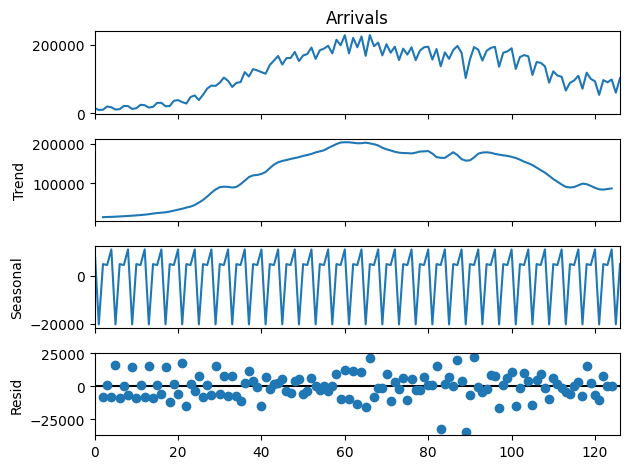

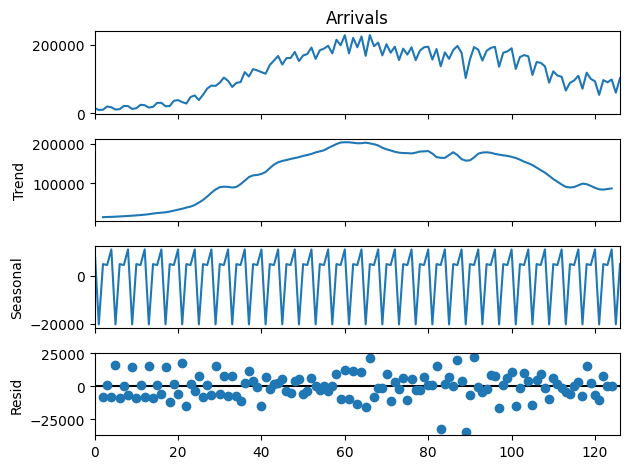

In [ ]:
# Every even observation (even leap), there is decreasing mechanism
res.plot()

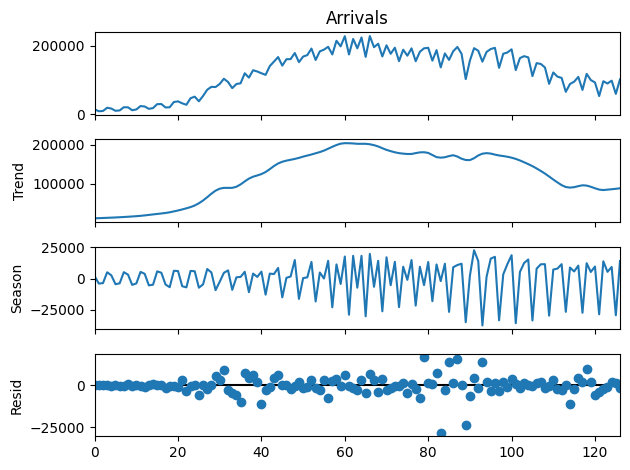

In [ ]:
# STL
from statsmodels.tsa.seasonal import STL
stl = STL(data_jpn["Arrivals"],
          period = 4,
          seasonal = 5)
result = stl.fit()

fig = result.plot()

In [ ]:
# See what data in even observation
# Logic, since the index started in zero, 1st index must be even observation (2nd obs) and so on
# Hence, we find odd indexes for even observation

# As we see, even observations 2nd and 4th quarter.
# It is weird that plane arrivals decline every even observation
# I assume that 1st and 3rd quarter are peak seasons. Otherwise are off-peak seasons (schedule adjustment)
# It is behave such so because no
even_index_rows = data_jpn[data_jpn.index % 2 != 0]
print(even_index_rows)

       Quarter Origin  Arrivals  Year  Quarter_Num  Rolling_Avg
1   1981-04-01  Japan      9321  1981            2          NaN
3   1981-10-01  Japan     19509  1981            4          NaN
5   1982-04-01  Japan     10617  1982            2    15012.375
7   1982-10-01  Japan     20961  1982            4    15926.750
9   1983-04-01  Japan     12235  1983            2    17290.000
..         ...    ...       ...   ...          ...          ...
117 2010-04-01  Japan     71253  2010            2    92551.250
119 2010-10-01  Japan     99987  2010            4    92019.375
121 2011-04-01  Japan     53397  2011            2    89993.625
123 2011-10-01  Japan     89900  2011            4    86560.000
125 2012-04-01  Japan     59760  2012            2          NaN

[63 rows x 6 columns]


# Stationarity

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Apply Augmented Dickey-Fuller test
result = adfuller(data_jpn['Arrivals'])

# Extract and display the results
# Default: random walk with drift
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -2.2446525206741144
p-value: 0.19043995066528874
Critical Values: {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}


In [ ]:
# Apply Augmented Dickey-Fuller test: pure random walk
result = adfuller(data_jpn['Arrivals'], regression='n')

# Extract and display the results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

In [ ]:
# Apply Augmented Dickey-Fuller test: random walk with drift and trend (linear trend)
result = adfuller(data_jpn['Arrivals'], regression='ct')

# Extract and display the results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -1.2240778377082793
p-value: 0.9054517852775903
Critical Values: {'1%': -4.038307389431779, '5%': -3.448703208559121, '10%': -3.149449845280976}


In [ ]:
# Apply Augmented Dickey-Fuller test: random walk with drift and trend (not linear trend)
result = adfuller(data_jpn['Arrivals'], regression='ctt')

# Extract and display the results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -3.4261733256456766
p-value: 0.13275572036649735
Critical Values: {'1%': -4.47299964004413, '5%': -3.8838523328481975, '10%': -3.584964977669387}


The presence of trend and seasonal component makes the data generation is not from a stationary process.